In [1]:
'''Three approaches that are commonly used in the industry are

Parametric
Historical Simulation
Monte Carlo Simulation'''

'Three approaches that are commonly used in the industry are\n\nParametric\nHistorical Simulation\nMonte Carlo Simulation'

In [3]:
#Import Libraries

import pandas as pd
import numpy as np
from numpy.linalg import multi_dot

from scipy.stats import norm
from tabulate import tabulate

import matplotlib.pyplot as plt

In [4]:
#Retrieve Data

# Load locally stored data
df = pd.read_csv('faang_stocks.csv', parse_dates=True, index_col=0)['2013':]

# Check first 5 values 
df.head()

,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2013-01-02,68.502106,257.309998,28.000000,360.274597,13.144286
2013-01-03,67.637436,258.480011,27.770000,360.483826,13.798572
2013-01-04,65.753418,259.149994,28.760000,367.607117,13.711429
2013-01-07,65.366646,268.459991,29.420000,366.003143,14.171429
2013-01-08,65.542587,266.380005,29.059999,365.280823,13.880000


In [5]:
# Calculate Returns

# Calculate daily returns
returns = df.pct_change().dropna()

C:\Software\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


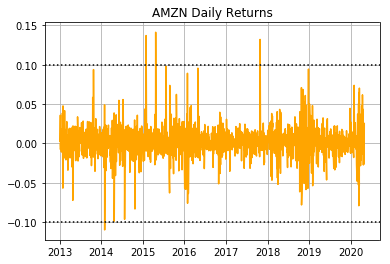

In [6]:
# Visualize AMZN daily returns
plt.plot(returns['AMZN'], color='orange')
plt.axhline(y=0.10, ls='dotted', color='black')
plt.axhline(y=-0.10, ls='dotted', color='black')
plt.title('AMZN Daily Returns')
plt.grid(True)

In [16]:
## Parametric VaR

In [7]:
# Calculate mean and standard deviation 
mean = np.mean(returns['AMZN'])
stdev = np.std(returns['AMZN'])

# Calculate VaR at difference confidence level
VaR_90 = norm.ppf(1-0.90,mean,stdev)
VaR_95 = norm.ppf(1-0.95,mean,stdev) #norm.ppf(0.05)
VaR_99 = norm.ppf(1-0.99,mean,stdev)

In [8]:
# Ouput results in tabular format
table = [['90%', VaR_90],['95%', VaR_95],['99%', VaR_99] ]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(table,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0230125
95%                      -0.0299292
99%                      -0.0429039


In [9]:
# VaR function
def VaR(symbol, cl=0.95):
    mean = np.mean(returns[symbol])
    stdev = np.std(returns[symbol])
    
    return np.around(100*norm.ppf(1-cl,mean,stdev),4)

#ppf is the inverse CDF

In [11]:
# VaR for stocks
print('VaR for FAANG Stocks')
print('---'*11)
[print(f'VaR at 95% CL for {stock:4} : {VaR(stock)}%') for stock in df.columns][0]

VaR for FAANG Stocks
---------------------------------
VaR at 95% CL for AAPL : -2.7758%
VaR at 95% CL for AMZN : -2.9929%
VaR at 95% CL for FB   : -3.4005%
VaR at 95% CL for GOOG : -2.5582%
VaR at 95% CL for NFLX : -4.5729%


In [12]:
# Visualize VaR at 95% confidence level

In [13]:
num_of_shares = 1000
price = df['AMZN'].iloc[-1]
position = num_of_shares * price 

amzn_var = position * VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var}')

Amazon Holding Value: 2372709.9609375
Amazon VaR at 99% confidence level is: -101798.41813580536


In [14]:
# VaR calculation by appling direct formulae
position * (mean + norm.ppf(1-0.99) * stdev)         # mean-2.33*stdev

-101798.41813580536

In [17]:
## Scaling VaR

In [18]:
forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)

In [19]:
ftable = [['90%', f_VaR_90],['95%', f_VaR_95],['99%', f_VaR_99] ]
fheader = ['Confidence Level', '5-Day Forecast Value At Risk']
print(tabulate(ftable,headers=fheader))

Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                     -0.0514574
95%                                     -0.0669237
99%                                     -0.0959359


In [20]:
amzn_var_5days = position * f_VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var_5days}')

Amazon Holding Value: 2372709.9609375
Amazon VaR at 99% confidence level is: -227628.1829536082


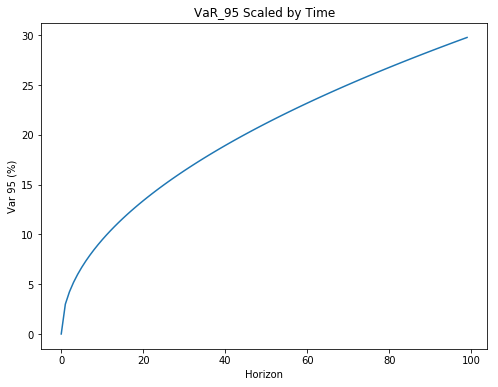

In [21]:
# Scaled VaR over different time horizon
plt.figure(figsize=(8,6))
plt.plot(range(100),[-100*VaR_95*np.sqrt(x) for x in range(100)])
plt.xlabel('Horizon')
plt.ylabel('Var 95 (%)')
plt.title('VaR_95 Scaled by Time');

In [22]:
## Historical VaR

In [23]:
# Use quantile function for Historical VaR
hVaR_90 = returns['AMZN'].quantile(0.10)
hVaR_95 = returns['AMZN'].quantile(0.05)
hVaR_99 = returns['AMZN'].quantile(0.01)

In [24]:
htable = [['90%', hVaR_90],['95%', hVaR_95],['99%', hVaR_99]]
print(tabulate(htable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0176864
95%                      -0.0270757
99%                      -0.0537678


In [25]:
## Expected Short Fall

In [26]:
# Calculate CVar
CVaR_90 = returns['AMZN'][returns['AMZN']<=hVaR_90].mean()
CVaR_95 = returns['AMZN'][returns['AMZN']<=hVaR_95].mean()
CVaR_99 = returns['AMZN'][returns['AMZN']<=hVaR_99].mean()

In [27]:
ctable = [['90%', CVaR_90],['95%', CVaR_95],['99%', CVaR_99] ]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable,headers=cheader))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0322919
95%                                  -0.0430837
99%                                  -0.0709137


In [28]:
## MonteCarlo VaR

In [29]:
# Set seed for reproducibility
np.random.seed(12345)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns,10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns,1)

In [30]:
mctable = [['90%', MCVaR_90],['95%', MCVaR_95],['99%', MCVaR_99]]
print(tabulate(mctable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.022716
95%                      -0.0296045
99%                      -0.0419563


In [31]:
## Portfolio VaR

In [32]:
# Assign Weights
wts = np.array([0.2,0.2,0.2,0.2,0.2])[:,np.newaxis]
wts

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])

In [33]:
# Portfolio return

# Stock returns
returns[:5]

,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2013-01-03,-0.012623,0.004547,-0.008214,0.000581,0.049777
2013-01-04,-0.027855,0.002592,0.035650,0.019760,-0.006315
2013-01-07,-0.005882,0.035925,0.022949,-0.004363,0.033549
2013-01-08,0.002692,-0.007748,-0.012237,-0.001974,-0.020565
2013-01-09,-0.015629,-0.000113,0.052650,0.006573,-0.012865


In [34]:
port_ret = np.dot(returns,wts)
port_ret.flatten()

array([ 0.00681364,  0.00476646,  0.01643538, ..., -0.00763758,
       -0.02829639,  0.04543993])

In [35]:
port_mean = port_ret.mean()
port_mean

0.0013435993118931643

In [36]:
# Portfolio Volatility

# Covariance matrix
returns.cov()

,AAPL,AMZN,FB,GOOG,NFLX
AAPL,0.000304,0.000140,0.000160,0.000148,0.000126
AMZN,0.000140,0.000363,0.000205,0.000185,0.000243
FB,0.000160,0.000205,0.000460,0.000192,0.000215
GOOG,0.000148,0.000185,0.000192,0.000258,0.000195
NFLX,0.000126,0.000243,0.000215,0.000195,0.000852


In [37]:
# Portfolio volatility
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
port_stdev.flatten()[0]

0.015303544566859555

In [40]:
# Portfolio Position
port_pos = (df.iloc[-1] * num_of_shares).sum()
port_pos

4607223.205566406

In [41]:
# Calculate Portfolio VaR at difference confidence level
pVaR_90 = norm.ppf(1-0.90,port_mean,port_stdev).flatten()[0]
pVaR_95 = norm.ppf(1-0.95,port_mean,port_stdev).flatten()[0]
pVaR_99 = norm.ppf(1-0.99,port_mean,port_stdev).flatten()[0]

In [42]:
pVaR_95

-0.02382849147411927

In [43]:
# Portfolio VaR

# Ouput results in tabular format
ptable = [['90%', pVaR_90],['95%', pVaR_95],['99%', pVaR_99]]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(ptable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0182687
95%                      -0.0238285
99%                      -0.0342578


In [44]:
# Iterate over symbols
for stock in df.columns:
    pos = df[stock].iloc[-1] * num_of_shares
    pvar = pos * VaR(stock)
    
    print(f'{stock} Holding Value: {pos:0.4}') 
    print(f'{stock} VaR at 95% confidence level: {pvar:0.4}')
    print()

print(f'Portfolio Holding Value: {port_pos:0.4}')
print(f'Portoflio VaR at 95% confidence level: {port_pos * pVaR_95:0.4}')

AAPL Holding Value: 2.87e+05
AAPL VaR at 95% confidence level: -7.965e+05

AMZN Holding Value: 2.373e+06
AMZN VaR at 95% confidence level: -7.101e+06

FB Holding Value: 1.942e+05
FB VaR at 95% confidence level: -6.603e+05

GOOG Holding Value: 1.341e+06
GOOG VaR at 95% confidence level: -3.432e+06

NFLX Holding Value: 4.119e+05
NFLX VaR at 95% confidence level: -1.884e+06

Portfolio Holding Value: 4.607e+06
Portoflio VaR at 95% confidence level: -1.098e+05
